In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from torch.amp import GradScaler, autocast
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 128
learning_rate = .00002
num_epochs = 100
loss_weights = (1.0, 1.0, .01, .01)

In [3]:
#LOAD DATASET

dataset = torch.load("dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

class MultiTaskV2(nn.Module):
    def __init__(self):
        super().__init__()

        self.cloud_mask_net = Unet(
            encoder_name='resnet34',
            in_channels=16,
            classes=1,
        )

        self.cloud_phase_net = Unet(
            encoder_name='resnet34',
            in_channels=17,
            classes=5,
        )
        self.cod_net = Unet(
            encoder_name='resnet34',
            in_channels=22,
            classes=1,
        )
        self.cps_net = Unet(
            encoder_name='resnet34',
            in_channels=22,
            classes=1,
        )

    def forward(self, x):
        cloud_mask_pred = self.cloud_mask_net(x)  # [B,1,H,W]
        x1 = torch.cat([x, cloud_mask_pred], dim=1)  # [B,17,H,W]
        cloud_phase_pred = self.cloud_phase_net(x1)  # [B,5,H,W]
        x2 = torch.cat([x1, cloud_phase_pred], dim=1)
        
        cod_pred = self.cod_net(x2)                # [B,1,H,W]
        cps_pred = self.cps_net(x2)                # [B,1,H,W]

        return cloud_mask_pred, cloud_phase_pred, cod_pred, cps_pred



In [6]:
#FINAL SETUP

dev_str = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(dev_str)
model = MultiTaskV2().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler(device = device)

def unpack_labels(labels):
    return (
        labels[:, 0:1, :, :],             # cloud_mask → [B, H, W]
        labels[:, 1, :, :].long(),        # cloud_phase → [B, H, W]
        labels[:, 2:3, :, :],             # cod → [B, 1, H, W]
        labels[:, 3:4, :, :]              # cps → [B, 1, H, W]
    )


train_mask_losses, train_phase_losses, train_cod_losses, train_cps_losses, train_all_losses = [], [], [], [], []
val_mask_losses, val_phase_losses, val_cod_losses, val_cps_losses, val_all_losses = [], [], [], [], []

train_mask_acc, train_phase_acc, train_cod_r2, train_cps_r2 = [], [], [], []
val_mask_acc, val_phase_acc, val_cod_r2, val_cps_r2 = [], [], [], []

In [7]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader, loss_weights=(1,1,1,1)):
    model.train()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in tqdm(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        optimizer.zero_grad()
        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        with autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            

        # Update model
        scaler.scale(total_batch_loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(train_loader),
        'loss_mask': total_loss_mask / len(train_loader),
        'loss_phase': total_loss_phase / len(train_loader),
        'loss_cod': total_loss_cod / len(train_loader),
        'loss_cps': total_loss_cps / len(train_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }



def eval(model, val_loader, loss_weights=(1,1,1,1)):
    model.eval()

    total_instances = 0 # Count number of instances in the epoch
    total_loss = total_loss_mask = total_loss_phase = total_loss_cod = total_loss_cps = 0 # Total loss and sublosses
    mask_correct = phase_correct = 0 # Number of correct guesses for cloud_mask and cloud_phase
    cod_preds, cod_labels = [], [] # Cod labels and predictions for calculating r2 
    cps_preds, cps_labels = [], [] # Cps labels and predictions for calculating r2

    for inputs, labels in (val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        cloud_mask_target, cloud_phase_target, cod_target, cps_target = unpack_labels(labels) # Get individual targets

        B, _, H, W = labels.shape
        total_instances += (B * H * W) # Count instances in batch
        
        
        with torch.no_grad(), autocast(device_type=dev_str):
            preds = model(inputs) # Model predictions

            # Loss in batch
            loss_mask = nn.BCEWithLogitsLoss()(preds[0], cloud_mask_target)
            loss_phase = nn.CrossEntropyLoss()(preds[1], cloud_phase_target)
            loss_cod = nn.MSELoss()(preds[2], cod_target)
            loss_cps = nn.MSELoss()(preds[3], cps_target)
            total_batch_loss = (
                loss_weights[0] * loss_mask +
                loss_weights[1] * loss_phase +
                loss_weights[2] * loss_cod +
                loss_weights[3] * loss_cps
            )

        # Get correct guesses for mask and phase
        mask_preds = (torch.sigmoid(preds[0]) > 0.5).long()
        mask_correct += (mask_preds == cloud_mask_target).sum().item()
        phase_preds = torch.argmax(preds[1], dim=1)
        phase_correct += (phase_preds == cloud_phase_target).sum().item()

        # Get predicted and actual cod and cps
        cod_preds.append(preds[2].cpu().detach().numpy())
        cod_labels.append(cod_target.cpu().numpy())
        cps_preds.append(preds[3].cpu().detach().numpy())
        cps_labels.append(cps_target.cpu().numpy())
            
        # Loss in epoch
        total_loss += total_batch_loss.item()
        total_loss_mask += loss_mask.item()
        total_loss_phase += loss_phase.item()
        total_loss_cod += loss_cod.item()
        total_loss_cps += loss_cps.item()

    # ------------------------------------ BATCH LOOP END -------------------------------------------------------------

    #Accuracy for mask and phase
    mask_accuracy = mask_correct/total_instances
    phase_accuracy = phase_correct/total_instances

    #Cod R2
    cod_preds = np.concatenate(cod_preds).ravel()
    cod_labels = np.concatenate(cod_labels).ravel()
    cod_r2 = r2_score(cod_labels, cod_preds)

    #Cps R2
    cps_preds = np.concatenate(cps_preds).ravel()
    cps_labels = np.concatenate(cps_labels).ravel()
    cps_r2 = r2_score(cps_labels, cps_preds)

    return {
        'loss_total': total_loss / len(val_loader),
        'loss_mask': total_loss_mask / len(val_loader),
        'loss_phase': total_loss_phase / len(val_loader),
        'loss_cod': total_loss_cod / len(val_loader),
        'loss_cps': total_loss_cps / len(val_loader),
        'acc_mask': mask_accuracy,
        'acc_phase': phase_accuracy,
        'r2_cod': cod_r2,
        'r2_cps': cps_r2
    }

In [8]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_results = train(model, train_loader, loss_weights = loss_weights)
    val_results = eval(model, val_loader, loss_weights = loss_weights)
    
    train_mask_losses.append(train_results['loss_mask'])
    train_phase_losses.append(train_results['loss_phase'])
    train_cod_losses.append(train_results['loss_cod'])
    train_cps_losses.append(train_results['loss_cps'])
    train_all_losses.append(train_results['loss_total'])

    train_mask_acc.append(train_results['acc_mask'])
    train_phase_acc.append(train_results['acc_phase'])
    train_cod_r2.append(train_results['r2_cod'])
    train_cps_r2.append(train_results['r2_cps'])

    val_mask_losses.append(val_results['loss_mask'])
    val_phase_losses.append(val_results['loss_phase'])
    val_cod_losses.append(val_results['loss_cod'])
    val_cps_losses.append(val_results['loss_cps'])
    val_all_losses.append(val_results['loss_total'])

    val_mask_acc.append(val_results['acc_mask'])
    val_phase_acc.append(val_results['acc_phase'])
    val_cod_r2.append(val_results['r2_cod'])
    val_cps_r2.append(val_results['r2_cps'])

    print(f"Epoch: {e} | Train Loss: {train_results['loss_total']:.4f} | Val Loss: {val_results['loss_total']:.4f} | Val Mask: {val_results['acc_mask']:.4f} | Val Phase: {val_results['acc_phase']:.4f} | Val Cod: {val_results['r2_cod']:.4f} | Val Cps: {val_results['r2_cps']:.4f}")


100%|██████████| 94/94 [00:27<00:00,  3.40it/s]


Epoch: 1 | Train Loss: 4.3865 | Val Loss: 3.8199 | Val Mask: 0.8661 | Val Phase: 0.6361 | Val Cod: -0.1362 | Val Cps: -0.7125


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 2 | Train Loss: 3.7774 | Val Loss: 3.4593 | Val Mask: 0.8913 | Val Phase: 0.6832 | Val Cod: -0.0779 | Val Cps: -0.5907


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 3 | Train Loss: 3.4871 | Val Loss: 3.4371 | Val Mask: 0.9120 | Val Phase: 0.6958 | Val Cod: -0.1584 | Val Cps: -0.6633


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 4 | Train Loss: 3.2773 | Val Loss: 3.3629 | Val Mask: 0.9159 | Val Phase: 0.7559 | Val Cod: -0.0534 | Val Cps: -0.7481


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 5 | Train Loss: 3.1240 | Val Loss: 2.9597 | Val Mask: 0.9300 | Val Phase: 0.7728 | Val Cod: -0.0270 | Val Cps: -0.4826


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 6 | Train Loss: 2.9961 | Val Loss: 3.0985 | Val Mask: 0.9283 | Val Phase: 0.7860 | Val Cod: -0.0434 | Val Cps: -0.6537


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 7 | Train Loss: 2.8796 | Val Loss: 3.0796 | Val Mask: 0.9353 | Val Phase: 0.7491 | Val Cod: -0.0703 | Val Cps: -0.5693


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 8 | Train Loss: 2.7858 | Val Loss: 2.8578 | Val Mask: 0.9327 | Val Phase: 0.7535 | Val Cod: -0.0110 | Val Cps: -0.4076


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 9 | Train Loss: 2.6912 | Val Loss: 2.9433 | Val Mask: 0.9137 | Val Phase: 0.7637 | Val Cod: -0.0322 | Val Cps: -0.4827


100%|██████████| 94/94 [00:25<00:00,  3.75it/s]


Epoch: 10 | Train Loss: 2.6054 | Val Loss: 2.7008 | Val Mask: 0.9428 | Val Phase: 0.7976 | Val Cod: 0.1322 | Val Cps: -0.4634


100%|██████████| 94/94 [00:25<00:00,  3.73it/s]


Epoch: 11 | Train Loss: 2.5369 | Val Loss: 2.7607 | Val Mask: 0.9263 | Val Phase: 0.7993 | Val Cod: -0.0197 | Val Cps: -0.4270


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 12 | Train Loss: 2.4631 | Val Loss: 2.8249 | Val Mask: 0.9444 | Val Phase: 0.7535 | Val Cod: 0.1353 | Val Cps: -0.4771


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 13 | Train Loss: 2.4106 | Val Loss: 2.4199 | Val Mask: 0.9440 | Val Phase: 0.7994 | Val Cod: 0.0960 | Val Cps: -0.2083


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 14 | Train Loss: 2.3370 | Val Loss: 2.6522 | Val Mask: 0.9205 | Val Phase: 0.7867 | Val Cod: 0.1440 | Val Cps: -0.3780


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 15 | Train Loss: 2.2744 | Val Loss: 2.6705 | Val Mask: 0.9475 | Val Phase: 0.8046 | Val Cod: 0.0150 | Val Cps: -0.4292


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 16 | Train Loss: 2.2187 | Val Loss: 2.7541 | Val Mask: 0.9371 | Val Phase: 0.7505 | Val Cod: 0.1238 | Val Cps: -0.4139


100%|██████████| 94/94 [00:24<00:00,  3.90it/s]


Epoch: 17 | Train Loss: 2.1601 | Val Loss: 2.5191 | Val Mask: 0.9483 | Val Phase: 0.7958 | Val Cod: 0.0043 | Val Cps: -0.2684


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 18 | Train Loss: 2.1028 | Val Loss: 2.5794 | Val Mask: 0.9062 | Val Phase: 0.7880 | Val Cod: 0.2361 | Val Cps: -0.3280


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 19 | Train Loss: 2.0403 | Val Loss: 2.2798 | Val Mask: 0.9404 | Val Phase: 0.8148 | Val Cod: -0.0341 | Val Cps: -0.0635


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 20 | Train Loss: 1.9900 | Val Loss: 2.5620 | Val Mask: 0.9358 | Val Phase: 0.7506 | Val Cod: 0.1318 | Val Cps: -0.2379


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 21 | Train Loss: 1.9390 | Val Loss: 2.5969 | Val Mask: 0.9453 | Val Phase: 0.7377 | Val Cod: 0.1259 | Val Cps: -0.2651


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 22 | Train Loss: 1.8891 | Val Loss: 2.1652 | Val Mask: 0.9484 | Val Phase: 0.8095 | Val Cod: 0.1220 | Val Cps: -0.0377


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 23 | Train Loss: 1.8430 | Val Loss: 2.3341 | Val Mask: 0.9516 | Val Phase: 0.8235 | Val Cod: 0.2167 | Val Cps: -0.2830


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 24 | Train Loss: 1.7912 | Val Loss: 2.1466 | Val Mask: 0.9524 | Val Phase: 0.8264 | Val Cod: 0.1832 | Val Cps: -0.0929


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 25 | Train Loss: 1.7490 | Val Loss: 2.3886 | Val Mask: 0.9497 | Val Phase: 0.8254 | Val Cod: 0.2050 | Val Cps: -0.3182


100%|██████████| 94/94 [00:24<00:00,  3.91it/s]


Epoch: 26 | Train Loss: 1.6998 | Val Loss: 2.4681 | Val Mask: 0.9142 | Val Phase: 0.8224 | Val Cod: 0.2612 | Val Cps: -0.3182


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 27 | Train Loss: 1.6581 | Val Loss: 2.7255 | Val Mask: 0.9365 | Val Phase: 0.7606 | Val Cod: -0.2091 | Val Cps: -0.2979


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 28 | Train Loss: 1.6276 | Val Loss: 2.6864 | Val Mask: 0.9154 | Val Phase: 0.7885 | Val Cod: -0.0283 | Val Cps: -0.3256


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 29 | Train Loss: 1.5879 | Val Loss: 2.5916 | Val Mask: 0.9339 | Val Phase: 0.5521 | Val Cod: 0.2268 | Val Cps: 0.1947


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 30 | Train Loss: 1.5429 | Val Loss: 2.1297 | Val Mask: 0.9165 | Val Phase: 0.8295 | Val Cod: 0.1866 | Val Cps: 0.0156


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 31 | Train Loss: 1.5153 | Val Loss: 1.9862 | Val Mask: 0.9519 | Val Phase: 0.8238 | Val Cod: 0.2154 | Val Cps: 0.0507


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 32 | Train Loss: 1.4736 | Val Loss: 2.3556 | Val Mask: 0.9375 | Val Phase: 0.8384 | Val Cod: 0.2763 | Val Cps: -0.3324


100%|██████████| 94/94 [00:25<00:00,  3.64it/s]


Epoch: 33 | Train Loss: 1.4401 | Val Loss: 2.3525 | Val Mask: 0.9539 | Val Phase: 0.8124 | Val Cod: 0.2736 | Val Cps: -0.2747


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 34 | Train Loss: 1.4121 | Val Loss: 2.0501 | Val Mask: 0.9495 | Val Phase: 0.8169 | Val Cod: 0.1156 | Val Cps: 0.0386


100%|██████████| 94/94 [00:24<00:00,  3.78it/s]


Epoch: 35 | Train Loss: 1.3840 | Val Loss: 1.9126 | Val Mask: 0.9549 | Val Phase: 0.8357 | Val Cod: 0.0525 | Val Cps: 0.1522


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 36 | Train Loss: 1.3486 | Val Loss: 2.1009 | Val Mask: 0.9480 | Val Phase: 0.7463 | Val Cod: 0.1926 | Val Cps: 0.1486


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 37 | Train Loss: 1.3177 | Val Loss: 1.8233 | Val Mask: 0.9291 | Val Phase: 0.8302 | Val Cod: 0.2981 | Val Cps: 0.2012


100%|██████████| 94/94 [00:25<00:00,  3.74it/s]


Epoch: 38 | Train Loss: 1.2877 | Val Loss: 1.8054 | Val Mask: 0.9526 | Val Phase: 0.8128 | Val Cod: 0.2794 | Val Cps: 0.1982


100%|██████████| 94/94 [00:24<00:00,  3.76it/s]


Epoch: 39 | Train Loss: 1.2618 | Val Loss: 1.6946 | Val Mask: 0.9558 | Val Phase: 0.7914 | Val Cod: 0.2156 | Val Cps: 0.3750


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 40 | Train Loss: 1.2373 | Val Loss: 1.7902 | Val Mask: 0.9239 | Val Phase: 0.8050 | Val Cod: 0.2244 | Val Cps: 0.3575


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 41 | Train Loss: 1.2167 | Val Loss: 2.0819 | Val Mask: 0.9345 | Val Phase: 0.8325 | Val Cod: 0.2590 | Val Cps: -0.0225


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 42 | Train Loss: 1.1949 | Val Loss: 1.9522 | Val Mask: 0.9402 | Val Phase: 0.8203 | Val Cod: 0.1914 | Val Cps: 0.1026


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 43 | Train Loss: 1.1673 | Val Loss: 1.8347 | Val Mask: 0.9525 | Val Phase: 0.8167 | Val Cod: 0.2597 | Val Cps: 0.1686


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 44 | Train Loss: 1.1506 | Val Loss: 2.4391 | Val Mask: 0.8988 | Val Phase: 0.6221 | Val Cod: 0.2708 | Val Cps: 0.3473


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 45 | Train Loss: 1.1262 | Val Loss: 1.8631 | Val Mask: 0.9520 | Val Phase: 0.8237 | Val Cod: 0.1275 | Val Cps: 0.2156


100%|██████████| 94/94 [00:24<00:00,  3.80it/s]


Epoch: 46 | Train Loss: 1.1098 | Val Loss: 1.7100 | Val Mask: 0.9369 | Val Phase: 0.8372 | Val Cod: 0.2869 | Val Cps: 0.2865


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 47 | Train Loss: 1.0876 | Val Loss: 1.7357 | Val Mask: 0.9591 | Val Phase: 0.8198 | Val Cod: 0.0885 | Val Cps: 0.3716


100%|██████████| 94/94 [00:25<00:00,  3.67it/s]


Epoch: 48 | Train Loss: 1.0749 | Val Loss: 1.6362 | Val Mask: 0.9590 | Val Phase: 0.8362 | Val Cod: 0.2737 | Val Cps: 0.3334


100%|██████████| 94/94 [00:24<00:00,  3.77it/s]


Epoch: 49 | Train Loss: 1.0479 | Val Loss: 1.7181 | Val Mask: 0.9537 | Val Phase: 0.7742 | Val Cod: 0.3243 | Val Cps: 0.3743


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 50 | Train Loss: 1.0346 | Val Loss: 1.8837 | Val Mask: 0.9478 | Val Phase: 0.7943 | Val Cod: -0.2061 | Val Cps: 0.3817


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 51 | Train Loss: 1.0205 | Val Loss: 1.6622 | Val Mask: 0.9566 | Val Phase: 0.8117 | Val Cod: 0.3307 | Val Cps: 0.3073


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 52 | Train Loss: 1.0036 | Val Loss: 1.8146 | Val Mask: 0.9593 | Val Phase: 0.8163 | Val Cod: 0.1744 | Val Cps: 0.2538


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 53 | Train Loss: 0.9912 | Val Loss: 1.9452 | Val Mask: 0.9562 | Val Phase: 0.7611 | Val Cod: 0.1743 | Val Cps: 0.2496


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 54 | Train Loss: 0.9747 | Val Loss: 1.5724 | Val Mask: 0.9602 | Val Phase: 0.8458 | Val Cod: 0.2391 | Val Cps: 0.3599


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 55 | Train Loss: 0.9637 | Val Loss: 2.2126 | Val Mask: 0.9478 | Val Phase: 0.7800 | Val Cod: 0.3145 | Val Cps: -0.0722


100%|██████████| 94/94 [00:24<00:00,  3.89it/s]


Epoch: 56 | Train Loss: 0.9430 | Val Loss: 1.4264 | Val Mask: 0.9508 | Val Phase: 0.8488 | Val Cod: 0.3423 | Val Cps: 0.4524


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 57 | Train Loss: 0.9329 | Val Loss: 1.7267 | Val Mask: 0.9446 | Val Phase: 0.8358 | Val Cod: 0.1945 | Val Cps: 0.3220


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 58 | Train Loss: 0.9201 | Val Loss: 1.4961 | Val Mask: 0.9612 | Val Phase: 0.8540 | Val Cod: 0.1416 | Val Cps: 0.4378


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 59 | Train Loss: 0.9097 | Val Loss: 1.5909 | Val Mask: 0.9567 | Val Phase: 0.8292 | Val Cod: 0.3454 | Val Cps: 0.4083


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 60 | Train Loss: 0.8960 | Val Loss: 1.4191 | Val Mask: 0.9614 | Val Phase: 0.8432 | Val Cod: 0.2767 | Val Cps: 0.4746


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 61 | Train Loss: 0.8913 | Val Loss: 1.5340 | Val Mask: 0.9501 | Val Phase: 0.8550 | Val Cod: 0.1558 | Val Cps: 0.4295


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 62 | Train Loss: 0.8800 | Val Loss: 1.4424 | Val Mask: 0.9509 | Val Phase: 0.8372 | Val Cod: 0.3339 | Val Cps: 0.4858


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 63 | Train Loss: 0.8725 | Val Loss: 2.0230 | Val Mask: 0.9553 | Val Phase: 0.8176 | Val Cod: -0.8438 | Val Cps: 0.4485


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 64 | Train Loss: 0.8667 | Val Loss: 1.4696 | Val Mask: 0.9575 | Val Phase: 0.8327 | Val Cod: 0.3515 | Val Cps: 0.4565


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 65 | Train Loss: 0.8536 | Val Loss: 1.9408 | Val Mask: 0.9537 | Val Phase: 0.8289 | Val Cod: -0.4631 | Val Cps: 0.4320


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 66 | Train Loss: 0.8483 | Val Loss: 1.6113 | Val Mask: 0.9611 | Val Phase: 0.8468 | Val Cod: 0.2326 | Val Cps: 0.2950


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 67 | Train Loss: 0.8332 | Val Loss: 1.5009 | Val Mask: 0.9336 | Val Phase: 0.8464 | Val Cod: 0.3695 | Val Cps: 0.4542


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 68 | Train Loss: 0.8298 | Val Loss: 1.6601 | Val Mask: 0.9584 | Val Phase: 0.8376 | Val Cod: 0.0360 | Val Cps: 0.4029


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 69 | Train Loss: 0.8232 | Val Loss: 1.4906 | Val Mask: 0.9586 | Val Phase: 0.8230 | Val Cod: 0.2405 | Val Cps: 0.4817


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 70 | Train Loss: 0.8251 | Val Loss: 1.4160 | Val Mask: 0.9555 | Val Phase: 0.8564 | Val Cod: 0.2492 | Val Cps: 0.4949


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 71 | Train Loss: 0.8145 | Val Loss: 1.5201 | Val Mask: 0.9613 | Val Phase: 0.8305 | Val Cod: 0.2756 | Val Cps: 0.4949


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 72 | Train Loss: 0.8050 | Val Loss: 1.3472 | Val Mask: 0.9611 | Val Phase: 0.8465 | Val Cod: 0.3854 | Val Cps: 0.5119


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 73 | Train Loss: 0.7942 | Val Loss: 1.4317 | Val Mask: 0.9470 | Val Phase: 0.8558 | Val Cod: 0.3829 | Val Cps: 0.4260


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 74 | Train Loss: 0.7901 | Val Loss: 1.5636 | Val Mask: 0.9347 | Val Phase: 0.8374 | Val Cod: 0.3750 | Val Cps: 0.4461


100%|██████████| 94/94 [00:24<00:00,  3.82it/s]


Epoch: 75 | Train Loss: 0.7916 | Val Loss: 1.4890 | Val Mask: 0.9601 | Val Phase: 0.8252 | Val Cod: 0.1494 | Val Cps: 0.5104


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 76 | Train Loss: 0.7853 | Val Loss: 1.4122 | Val Mask: 0.9550 | Val Phase: 0.8412 | Val Cod: 0.3608 | Val Cps: 0.5165


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 77 | Train Loss: 0.7783 | Val Loss: 2.6306 | Val Mask: 0.9611 | Val Phase: 0.7938 | Val Cod: -2.1662 | Val Cps: 0.4916


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 78 | Train Loss: 0.7720 | Val Loss: 1.3714 | Val Mask: 0.9627 | Val Phase: 0.8414 | Val Cod: 0.2626 | Val Cps: 0.5262


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 79 | Train Loss: 0.7671 | Val Loss: 1.3494 | Val Mask: 0.9565 | Val Phase: 0.8425 | Val Cod: 0.4142 | Val Cps: 0.5035


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 80 | Train Loss: 0.7631 | Val Loss: 1.6262 | Val Mask: 0.9567 | Val Phase: 0.8179 | Val Cod: 0.3563 | Val Cps: 0.4849


100%|██████████| 94/94 [00:24<00:00,  3.88it/s]


Epoch: 81 | Train Loss: 0.7576 | Val Loss: 1.3660 | Val Mask: 0.9588 | Val Phase: 0.8378 | Val Cod: 0.4139 | Val Cps: 0.4906


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 82 | Train Loss: 0.7557 | Val Loss: 1.5890 | Val Mask: 0.9628 | Val Phase: 0.7939 | Val Cod: 0.2679 | Val Cps: 0.4459


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 83 | Train Loss: 0.7536 | Val Loss: 1.5243 | Val Mask: 0.9571 | Val Phase: 0.8400 | Val Cod: 0.2767 | Val Cps: 0.4616


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 84 | Train Loss: 0.7531 | Val Loss: 1.8120 | Val Mask: 0.9628 | Val Phase: 0.7625 | Val Cod: 0.1900 | Val Cps: 0.4070


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 85 | Train Loss: 0.7473 | Val Loss: 1.6608 | Val Mask: 0.9398 | Val Phase: 0.7752 | Val Cod: 0.3259 | Val Cps: 0.5133


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 86 | Train Loss: 0.7454 | Val Loss: 1.3800 | Val Mask: 0.9588 | Val Phase: 0.8522 | Val Cod: 0.4194 | Val Cps: 0.4364


100%|██████████| 94/94 [00:24<00:00,  3.79it/s]


Epoch: 87 | Train Loss: 0.7403 | Val Loss: 1.8931 | Val Mask: 0.9626 | Val Phase: 0.7242 | Val Cod: -0.0279 | Val Cps: 0.5225


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 88 | Train Loss: 0.7377 | Val Loss: 1.7050 | Val Mask: 0.9611 | Val Phase: 0.7383 | Val Cod: 0.3446 | Val Cps: 0.5189


100%|██████████| 94/94 [00:24<00:00,  3.85it/s]


Epoch: 89 | Train Loss: 0.7360 | Val Loss: 1.3615 | Val Mask: 0.9632 | Val Phase: 0.8415 | Val Cod: 0.4171 | Val Cps: 0.5211


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 90 | Train Loss: 0.7350 | Val Loss: 1.4056 | Val Mask: 0.9556 | Val Phase: 0.8504 | Val Cod: 0.3403 | Val Cps: 0.4730


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 91 | Train Loss: 0.7289 | Val Loss: 1.4291 | Val Mask: 0.9555 | Val Phase: 0.8415 | Val Cod: 0.4140 | Val Cps: 0.5083


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 92 | Train Loss: 0.7278 | Val Loss: 1.3082 | Val Mask: 0.9638 | Val Phase: 0.8483 | Val Cod: 0.3836 | Val Cps: 0.5274


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 93 | Train Loss: 0.7182 | Val Loss: 1.4815 | Val Mask: 0.9629 | Val Phase: 0.8324 | Val Cod: 0.0744 | Val Cps: 0.5297


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 94 | Train Loss: 0.7197 | Val Loss: 1.5040 | Val Mask: 0.9508 | Val Phase: 0.8329 | Val Cod: 0.3659 | Val Cps: 0.5031


100%|██████████| 94/94 [00:24<00:00,  3.84it/s]


Epoch: 95 | Train Loss: 0.7147 | Val Loss: 1.4943 | Val Mask: 0.9563 | Val Phase: 0.8084 | Val Cod: 0.4048 | Val Cps: 0.4900


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 96 | Train Loss: 0.7185 | Val Loss: 1.2921 | Val Mask: 0.9621 | Val Phase: 0.8510 | Val Cod: 0.3927 | Val Cps: 0.5310


100%|██████████| 94/94 [00:24<00:00,  3.86it/s]


Epoch: 97 | Train Loss: 0.7138 | Val Loss: 1.3857 | Val Mask: 0.9627 | Val Phase: 0.8521 | Val Cod: 0.3809 | Val Cps: 0.5030


100%|██████████| 94/94 [00:24<00:00,  3.83it/s]


Epoch: 98 | Train Loss: 0.7078 | Val Loss: 1.3909 | Val Mask: 0.9608 | Val Phase: 0.8514 | Val Cod: 0.2944 | Val Cps: 0.4970


100%|██████████| 94/94 [00:24<00:00,  3.87it/s]


Epoch: 99 | Train Loss: 0.7052 | Val Loss: 1.4208 | Val Mask: 0.9641 | Val Phase: 0.8455 | Val Cod: 0.3226 | Val Cps: 0.5311


100%|██████████| 94/94 [00:24<00:00,  3.81it/s]


Epoch: 100 | Train Loss: 0.7052 | Val Loss: 1.3263 | Val Mask: 0.9628 | Val Phase: 0.8432 | Val Cod: 0.3786 | Val Cps: 0.5300


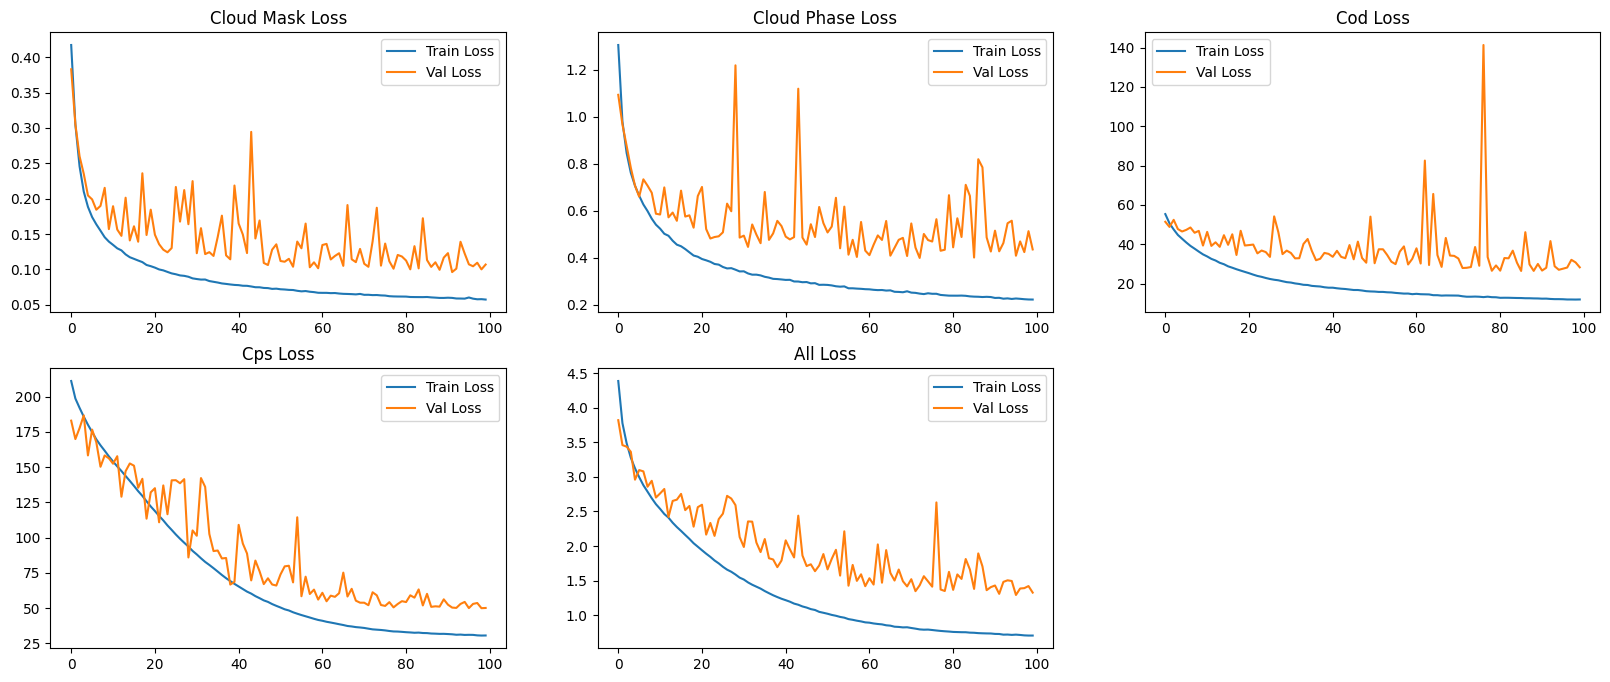

In [9]:
#PLOT LOSS

plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(train_mask_losses, label='Train Loss')
plt.plot(val_mask_losses, label='Val Loss')
plt.title('Cloud Mask Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(train_phase_losses, label='Train Loss')
plt.plot(val_phase_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(train_cod_losses, label='Train Loss')
plt.plot(val_cod_losses, label='Val Loss')
plt.title('Cod Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(train_cps_losses, label='Train Loss')
plt.plot(val_cps_losses, label='Val Loss')
plt.title('Cps Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(train_all_losses, label='Train Loss')
plt.plot(val_all_losses, label='Val Loss')
plt.title('All Loss')
plt.legend()

plt.savefig("./graphs/MultiTaskV2_loss.png")  

plt.show()

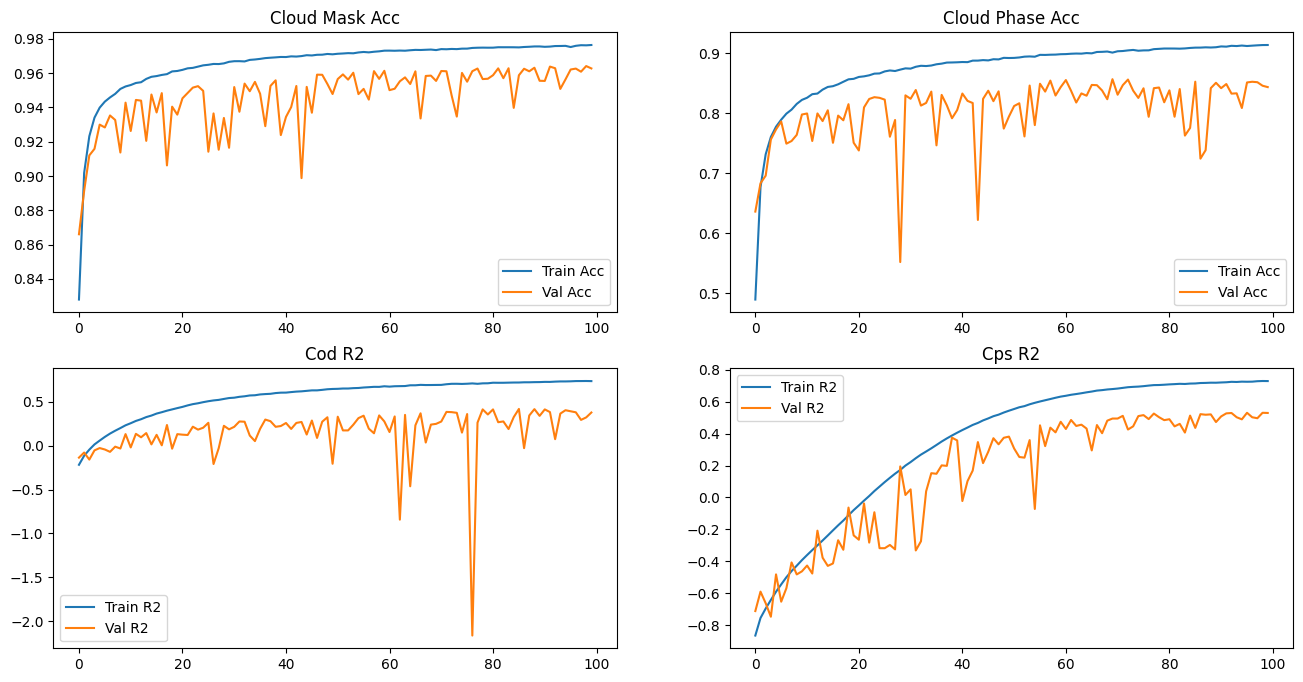

<Figure size 640x480 with 0 Axes>

In [10]:
#PLOT ACCURACY

plt.figure(figsize=(16,8))

plt.subplot(2, 2, 1)
plt.plot(train_mask_acc, label='Train Acc')
plt.plot(val_mask_acc, label='Val Acc')
plt.title('Cloud Mask Acc')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_phase_acc, label='Train Acc')
plt.plot(val_phase_acc, label='Val Acc')
plt.title('Cloud Phase Acc')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(train_cod_r2, label='Train R2')
plt.plot(val_cod_r2, label='Val R2')
plt.title('Cod R2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_cps_r2, label='Train R2')
plt.plot(val_cps_r2, label='Val R2')
plt.title('Cps R2')
plt.legend()

plt.show()

plt.savefig("./graphs/MultiTaskV2_acc.png")  

In [11]:
# MODEL EVALUATION — CLOUD MASK

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        cloud_mask_target, _, _, _ = unpack_labels(labels)
        cloud_mask_pred, _, _, _ = model(images)

        probs = torch.sigmoid(cloud_mask_pred)
        preds = (probs > 0.5).long()

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_mask_target.cpu().numpy())

# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(
    all_labels, all_preds,
    labels=[0, 1],
    digits=3,
    output_dict=True,
    zero_division=0
)


# Output
print("CLOUD MASK REPORT:\n", classification_report(all_labels, all_preds, labels=[0, 1], digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds, labels=[0, 1]))

100%|██████████| 12/12 [00:02<00:00,  5.81it/s]


CLOUD MASK REPORT:
               precision    recall  f1-score   support

           0      0.917     0.912     0.914   5138541
           1      0.977     0.978     0.977  19437459

    accuracy                          0.964  24576000
   macro avg      0.947     0.945     0.946  24576000
weighted avg      0.964     0.964     0.964  24576000

CONFUSION MATRIX:
 [[ 4684746   453795]
 [  422681 19014778]]


In [12]:
# MODEL EVALUATION — CLOUD PHASE

num_classes = 5

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        _, cloud_phase_target, _, _ = unpack_labels(labels)
        _, cloud_phase_pred, _, _ = model(images)
        preds = torch.argmax(cloud_phase_pred, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(cloud_phase_target.cpu().numpy())
        
# Flatten predictions and labels
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])

# Classification report and IoU
report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

# Output
print("CLOUD PHASE REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted IoU:", np.mean(iou))
print("Weighted IoU:", np.average(iou, weights=supports))


100%|██████████| 12/12 [00:01<00:00,  8.39it/s]


CLOUD PHASE REPORT:
               precision    recall  f1-score   support

           0      0.839     0.930     0.882   3922449
           1      0.889     0.898     0.893  10943271
           2      0.912     0.631     0.746   3640071
           3      0.411     0.494     0.449   1192949
           4      0.818     0.875     0.846   4877260

    accuracy                          0.839  24576000
   macro avg      0.774     0.766     0.763  24576000
weighted avg      0.847     0.839     0.839  24576000

CONFUSION MATRIX:
 [[3648136  227030    5921    4341   37021]
 [ 618273 9823234   84592   56826  360346]
 [   3825  528161 2298099  660853  149133]
 [   1282   84110  114663  589883  403011]
 [  77843  392096   16211  122007 4269103]]

IOU: [0.78901272 0.80685847 0.59513764 0.2895876  0.73267046]
Unweighted IoU: 0.6426533783649098
Weighted IoU: 0.7328191683034372


In [13]:
# MODEL EVALUATION — CLOUD OPTICAL DISTANCE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, cod_target, _ = unpack_labels(labels)
        _, _, cod_pred, _ = model(images)
        
        all_preds.append(cod_pred.cpu().numpy().reshape(-1))
        all_labels.append(cod_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.68it/s]


r2: 0.3579985499382019
MSE: 29.798593521118164


In [14]:
# MODEL EVALUATION — CLOUD PARTICLE SIZE

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device).float()
        labels = labels.to(device)

        _, _, _, cps_target = unpack_labels(labels)
        _, _, _, cps_pred = model(images)
        
        all_preds.append(cps_pred.cpu().numpy().reshape(-1))
        all_labels.append(cps_target.cpu().numpy().reshape(-1))

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("r2:", r2_score(all_labels, all_preds))
print("MSE:", mean_squared_error(all_labels, all_preds))

100%|██████████| 12/12 [00:01<00:00,  8.64it/s]


r2: 0.5399267077445984
MSE: 50.91328048706055
